## Inverse Methods Project Workspace
### Eve Chase

In this notebook, I test several implementations of the statistical methodology presented in the paper "Counting and Confusion: Bayesian Rate Estimation with Multiple Populations" by Farr, Gair, Mandel, & Cutler, colloquially known as FGMC.

This methology allows you to infer the rate of astrophysical events (as opposed to noise) detected by gravitational-wave observatories, given a set of triggers with known signal to noise ratios (SNRs). 

In [92]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import gwrates.rates_tools as rt
from scipy.special import erfc, erfinv

# FGMC with two classes
Test FGMC when all samples are categorized as either foreground or background. There are no subdivisions of either category.

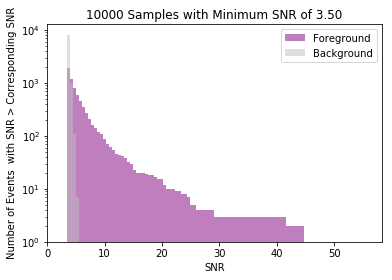

Number of Foreground:  1892
Number of Backgruond: 8108


In [2]:
# Set known parameters (Example 1 of FGMC paper)
num_samples = 10000
# rate_f = 10.4
# rate_b = 95.1

# FIXME: change SampleCollections to require num samples to be rate_f + rate_b
rate_f = 1930
rate_b = num_samples - rate_f
xmin = 3.5

collection = rt.SampleCollection(rate_f, rate_b, xmin)
collection.draw_samples(num_samples)
collection.plot_hist()
#collection.plot_cdf()


# Check Distributions
Check that the foreground and background distributions correspond to the expected distributions

/Users/eachase/miniconda3/envs/rates/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


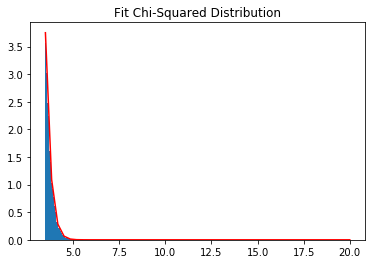

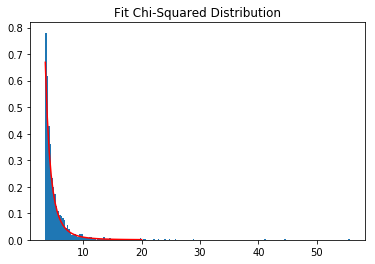

In [3]:
xrange = np.linspace(xmin, 20)

plt.figure()
bins = plt.hist(collection.background, bins=100, normed=True)
plt.plot(xrange, (np.sqrt(np.pi/2) * erfc(xmin / np.sqrt(2)))**(-1) * np.exp(-xrange**2 / 2), 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

plt.figure()
bins = plt.hist(collection.foreground, bins=200, normed=True)
plt.plot(xrange, bins[0][0] * 3 * xmin**3 / xrange **4, 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

## MCMC
Use an MCMC to with the FGMC methodology to find the underlying rates of foreground and background events.

In [4]:
# Draw from overall samples, assuming we don't know R_f and R_b
all_samples = np.asarray(collection.foreground + collection.background)

pos_true = [rate_f, rate_b]

ndim = 2
nwalkers=100

# Make initial guesses with dimensions (2 x nwalkers) -- FIXME: do this better
pos_init = [100 * np.random.rand(ndim) for i in np.arange(nwalkers)]

np.seterr(invalid='raise')

sampler = emcee.EnsembleSampler(nwalkers, ndim, rt.lnprob, args=[all_samples, xmin])    
sampler.run_mcmc(pos_init, 200)  
post_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))    


/Users/eachase/miniconda3/envs/rates/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


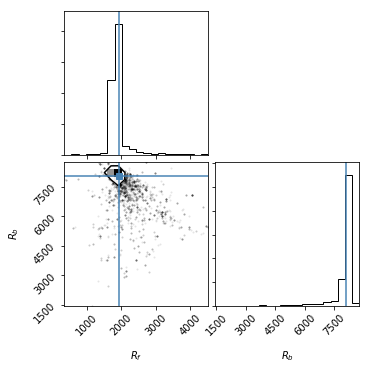

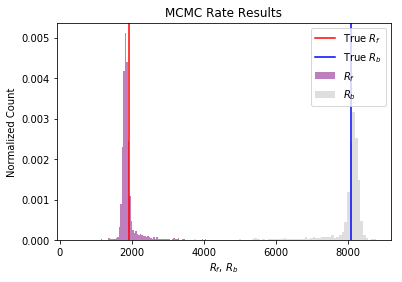

In [6]:
true_f = len(all_samples) * rate_f / (rate_f + rate_b)
true_b = len(all_samples) * rate_b / (rate_f + rate_b)

fig = corner.corner(post_samples, labels=["$R_f$", "$R_b$"], truths=[true_f , true_b])    

# plt.figure()
# plt.plot(sampler.chain[:, 50:, 0], color='k', alpha=0.2)
# plt.show()


# plt.figure()
# plt.plot(sampler.chain[:, 50:, 1], color='k', alpha=0.2, lw=0.5)
# plt.show()


plt.figure()
plt.hist(post_samples[:,0], bins=100, label=r'$R_{f}$', color='purple', alpha=0.5, normed=True)
plt.hist(post_samples[:,1], bins=100, label=r'$R_{b}$', color='0.75', alpha=0.5, normed=True)
plt.axvline(x=true_f, c='r', label=r'True $R_{f}$')
plt.axvline(x=true_b, c='b', label=r'True $R_{b}$')
plt.xlabel(r'$R_f$, $R_b$')
plt.ylabel('Normalized Count')
plt.title('MCMC Rate Results')
plt.legend(loc='upper right')
#plt.xlim(0,140)
plt.show()


## Gravity Spy
In this section, we obtain labels for the excess noise provided by the gravity spy system. Excess noise is identified by the Omicron algorithm that uses wavelets (i.e. sine-gaussians) for identifying excess noise. Therefore, the more a background excess noise event looks like a sine-gaussian the louder the SNR. In addition, restrictions of peak_frequency and SNR were supplied to Gravity Spy data. We only take Omicron triggers with a signal-to-noise ratio of 7.5 and greater and a peak_frequency between 10 and 2048.

These labels will need to be run over with a templated match filter. Of especial interest will be blip and scratch type excess noise.

This effort will be in parallel with finishing a study started so kindly by Laura Nutall and TJ Massinger about comparing omicron and pyCBC match filter values as well as running gravit spy over said events to get a "safety" check of sorts.

Individual Template Example:

https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/IMBH-SEOBRv4/IMBH-SEOBNRv4-newSNR-SNR.pdf

All Templates:
https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/

This section saves to one h5 file trigger info for human vetted and only machine learning vetted labels. The group is /humn

In [6]:
from gwpy.table import EventTable

# list all possible labels
gravityspy_classes =  ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 
                       'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 
                       'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
                       'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 
                       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 
                       'Violin_Mode', 'Wandering_Line', 'Whistle']

# Now we determine what types of labels we want: ML or ML + human
label_types = {'human':'Retired', 'machinelearning': '0.9'}

# what metadata do we want
columns = ['snr', 'Label', 'peakGPS']

for iclass in gravityspy_classes:
    for itype in label_types.keys():
        if itype == 'human':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"ImageStatus\" = \'Retired\''.format(
                                             iclass),
                                         columns=columns)
        elif itype == 'machinelearning':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"{0}\" > {1}'.format(
                                             iclass, label_types[itype]),
                                         columns=columns)

        tmp_table['Label'] = tmp_table['Label'].astype(str)
        tmp_table.write('gspytrigger.hdf5', path='{0}/{1}'.format(itype, iclass), format='hdf5', append=True)


ValueError: Remember to either pass or export GRAVITYSPY_DATABASE_USER and export GRAVITYSPY_DATABASE_PASSWD in order to access the Gravity Spy Data: https://secrets.ligo.org/secrets/144/ description is username and secret is password.

In [7]:
from gwpy.table import EventTable
from astropy.table import vstack

gravityspy_classes =  ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 
                       'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 
                       'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
                       'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 
                       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 
                       'Violin_Mode', 'Wandering_Line', 'Whistle']

background = []
# Read in gravityspy machine learning labels
for iclass in gravityspy_classes:
    background.append(EventTable.read('etc/gspytrigger.hdf5', path='human/{0}'.format(iclass), format='hdf5'))
    
background = vstack(background)
EventTable = EventTable(background)


/Users/eachase/miniconda3/envs/rates/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [188]:
class ManyBackgroundCollection(object):
    """
    A set of events with an associated ranking statistic.
    Events are divided into foreground and several different
    classes of background events.
    """
    def __init__(self, r_fg, r_gaussian, glitch_dict, xmin=3.5):

        """
        Initialize the sample collector

        Parameters:
        -----------
        r_fg: float
            known rate of foreground events

        r_gaussian: float
            known rate of gaussian noise background events

        glitch_dict: dictionary
            dictionary with glitch class as key (i.e. 'Scratchy')
            and corresponding rates as values

        xmin: float
            Minimum threshold SNR
        """
        

        self.xmin = xmin
        self.glitch_dict = glitch_dict
        self.r_fg = r_fg
        self.r_gaussian = r_gaussian
        #self.ratio_b = rate_b_true / (rate_f_true + rate_b_true)

        # Set up dictionary for different classes of events
        self.samples = {k: [] for k in ['Foreground', 'Gaussian'] + \
            list(glitch_dict.keys())}


        #self.bins = None
        
        
        
    def draw_samples(self):
        """
        Draw either a full set of foreground and background events
        """
        
#         num_samples = self.r_fg + self.r_gaussian + \
#             np.sum([r[0] for r in background_classes.values()])
            
#         ratio_gaussian = self.r_gaussian / (self.r_gaussian + self.r_fg)
        
        
        # Draw foreground samples
        for i in np.arange(self.r_fg):
            self.samples['Foreground'].append(self.xmin * (1 - np.random.uniform())**(-1/3))
            
        # Draw gaussian background samples
        for i in np.arange(self.r_gaussian):
            self.samples['Gaussian'].append(np.sqrt(2) * \
                erfinv(1 - (1 - np.random.uniform()) * erfc(self.xmin / np.sqrt(2))))
            
        # Define each glitch class to have SNRs defined in the glitch_dict    
        for glitch_class in self.glitch_dict:
            self.samples[glitch_class] = self.glitch_dict[glitch_class][1]
            
            
    def plot_hist(self):
        """
        Make a histogram of all drawn samples.
        """

        num_samples = num_samples = self.r_fg + self.r_gaussian + \
             np.sum([r[0] for r in background_classes.values()])
        num_classes = 2 + len(self.glitch_dict.keys())
        num_bins = int(np.floor(np.sqrt(num_samples)))
        colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

        plt.figure(figsize=(20,10))

        # Foreground histogram
        bin_counts, bins, _ = plt.hist(self.samples['Foreground'], label='Foreground', color=colors[0], bins=num_bins, cumulative=-1, histtype='step')

        # FIXME: Set bins on highest-SNR event, not just the foreground
        
        # Background histogram
        plt.hist(self.samples['Gaussian'], label='Gaussian', bins=bins, cumulative=-1, histtype='step', color=colors[1])

        # Other glitch class histograms
        for i, glitch_class in enumerate(self.glitch_dict):
            plt.hist(self.samples[glitch_class], label=glitch_class, color=colors[i+2], 
                    bins=bins, cumulative=-1, histtype='step')
        
        plt.legend(loc='upper right')
        plt.yscale('log', nonposy='clip')
        plt.xlim(0, None)
        plt.ylim(1, None)
        plt.xlabel('SNR')
        plt.ylabel('Number of Events  with SNR > Corresponding SNR')
        plt.title('%i Samples with Minimum SNR of %.2f' % (int(num_samples), self.xmin))
        plt.show()

 

In [186]:
# Define dictionary of general glitch classes
background_classes = {}

#for glitch_class in ['Blip', 'Scratchy', 'Tomte', 'Scattered_Light']:
for glitch_class in gravityspy_classes:
    glitch_table = background[background['Label'] == glitch_class]
    background_classes[glitch_class] = (len(glitch_table), np.asarray(glitch_table['snr']))
    #print(np.asarray(glitch_table['snr']))
        
# User selects total number of samples and foreground events
num_samples = 100000
r_f = 19300
# Gaussian noise accounts for all samples other than foreground and determined glitches
r_gaussian = num_samples - r_f - np.sum([r[0] for r in background_classes.values()])


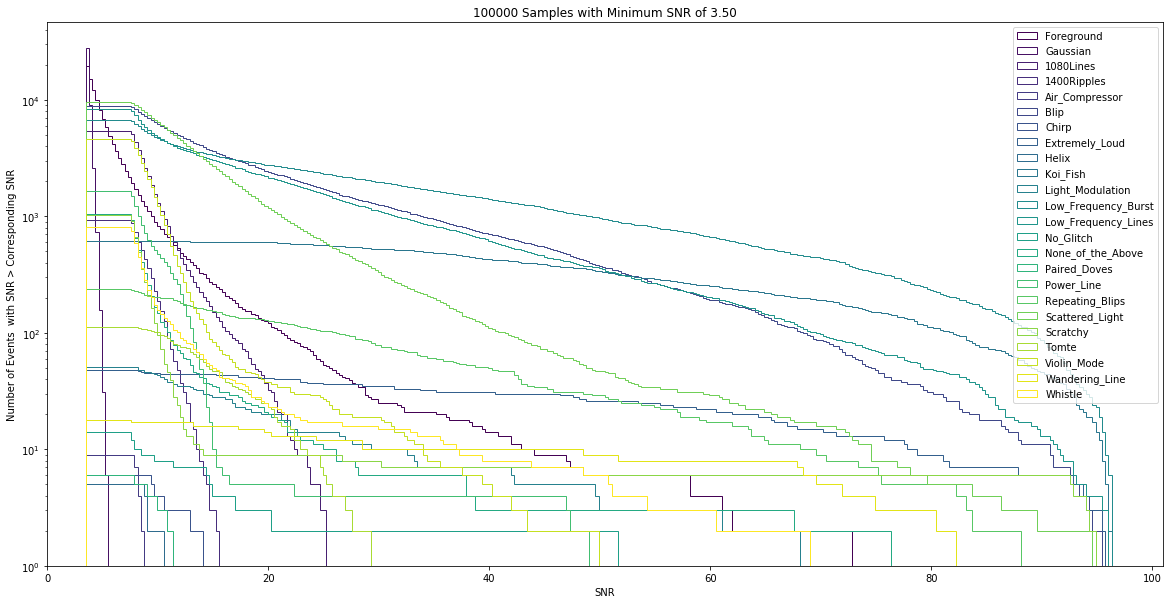

In [189]:
collection = ManyBackgroundCollection(r_f, r_gaussian, background_classes)
collection.draw_samples()
collection.plot_hist()

In [80]:
glitch_types = ['foreground', 'gaussian'] + list(background_classes.keys())
data = {k: [] for k in glitch_types}
data

{'foreground': [], 'gaussian': [], 'Blip': [], 'Scratchy': []}

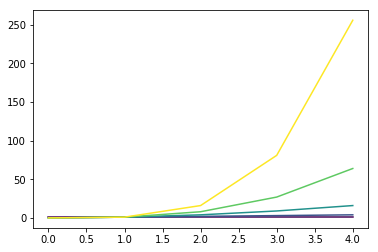

In [146]:
colors = plt.cm.viridis(np.linspace(0,1,5))

xrange = np.arange(5)
plt.figure()
for i in xrange:
    plt.plot(xrange, xrange**i, c=colors[i])
plt.show()
